# Sarsa
S1 A1 R2 S2 A2 ...
1. 无需定义状态转移，TD是无模型的：不了解MDP转换/奖励
2. 通过自举bootstraping从不完整的episodes中学习
3. 猜测episode结果，同时持续更新这个猜测
# TD(0)
朝着**估计回报**$R_{t+1}+\gamma V(S_{t+1})$的方向更新$V(S_{t}) $
$$V(S_{t})=V(S_{t}) + \alpha (R_{t+1}+\gamma V(S_{t+1}) -V(S_{t}))$$

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # tqdm是显示循环进度条的库

class CliffWalkingEnv:
    def __init__(self, ncol=12, nrow=4):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0 # agent x position
        self.y = self.nrow - 1 # agent y position
    
    def step(self, action): # action: 0, 1, 2, 3 for left, right, up, down
        # 外部调用step函数，传入action，返回下一个状态，奖励，是否终止
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done
    
    def reset(self) -> int: # 重置状态
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

# 维护Q表
维护一个表格``Q_table()``，用来存储当前策略下所有状态动作对的价值，在用Sarsa算法与环境交互时，用$\epsilon$贪婪策略进行采样，在更新Sarsa算法时，使用时序差分的公式。默认终止状态时所有动作的价值是0.这些价值在初始化为0后就不会进行更新。

In [ ]:
class Sarsa:
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.ncol = ncol
        self.nrow = nrow
        self.n_action = n_action
        self.epsilon = epsilon # epsilon-greedy
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor
        self.Q_table = np.zeros((nrow * ncol, n_action)) # Q table: nrow * ncol states, 4 actions
    
    def take_action(self, state) -> int:
        # epsilon-greedy策略选择动作
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_action)
        else:
            return np.argmax(self.Q_table[state]) # 选择Q值最大的动作: argmax(Q(s, a))，如果有多个最大值，随机选择一个
        
    def best_action(self, state): # 打印最优策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action): # 找到所有最优动作
            if self.Q_table[state][i] == Q_max:
                a[i] = 1
        return a
    
    def update(self, state, action, reward, next_state, next_action):
        # 更新Q值
        td_error = reward + self.gamma * self.Q_table[next_state][next_action] - self.Q_table[state][action]
        self.Q_table[state][action] += self.alpha * td_error

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 11340.25it/s, episode=500, return=-17.600]


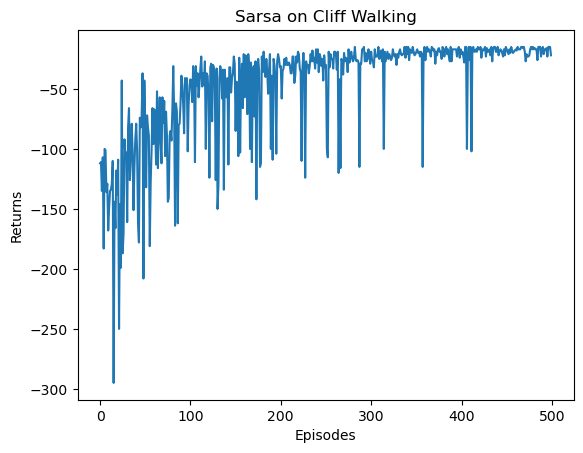

In [14]:
env = CliffWalkingEnv()
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 1
agent = Sarsa(env.ncol, env.nrow, epsilon, alpha, gamma)
n_episode = 500

return_list = [] # 记录每个episode的回报
for i in range(10):
    # tqdm是显示循环进度条的库
    with tqdm(total=int(n_episode / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(n_episode / 10)):
            episode_return = 0 # 记录每个episode的回报
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                agent.update(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
                episode_return += reward
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (n_episode / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)
            
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

In [15]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


action_meaning = ['^', 'v', '<', '>']
print('Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

Sarsa算法最终收敛得到的策略为：
ooo> ^ooo ooo> ooo> ooo> ooo> ooo> ovoo ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ^ooo ^ooo ooo> ^ooo ^ooo ooo> oo<o ^ooo ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [ ]:
class nstep_